In [1]:
#  1. Imports and Configuration
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from torchvision.models import ResNet50_Weights, MobileNet_V2_Weights, Inception_V3_Weights, EfficientNet_B0_Weights

# Config
DATA_DIR = "C:/Users/SDP87/Downloads/Images"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "valid")
TEST_DIR = os.path.join(DATA_DIR, "test")

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 0.001
NUM_CLASSES = 4
MODEL_PATH = "BEST_MODEL.pth"
BEST_MODEL_ACC = 0
BEST_MODEL = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
#  2. Data Transforms and Loaders (with Augmentation + ImageNet Normalization)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transform)
val_dataset   = datasets.ImageFolder(VAL_DIR, transform=val_test_transform)
test_dataset  = datasets.ImageFolder(TEST_DIR, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']


In [3]:
#  3. Train Function and Evaluate Function with Validation Accuracy + Time
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return 100 * correct / total

def train_model(model, train_loader, val_loader):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    print(f'{model}')
    # optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

    criterion = nn.CrossEntropyLoss()
    best_acc = 0

    for epoch in range(EPOCHS):
        start = time.time()
        model.train()
        total_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        end = time.time()

        print(f" Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.3f} | Val Acc: {val_acc:.2f}% | Time: {end-start:.1f}s")
        if val_acc > best_acc:
            best_acc = val_acc
        save(model,best_acc)

In [4]:
#  4.Class for Custom CNN model
class Custom_CNN(nn.Module):
    def __init__(self):
        super(Custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=1)
        self.conv4 = nn.Conv2d(64, 80, kernel_size=5, padding=1)
        self.conv5 = nn.Conv2d(80, 96, kernel_size=5, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(96 * 5 * 5, 512)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(-1, 96 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [5]:
#  5. Function for saving the best model
def save(model, model_acc):
    global BEST_MODEL_ACC,BEST_MODEL
    if model_acc > BEST_MODEL_ACC:
        BEST_MODEL_ACC = model_acc
        BEST_MODEL = model
        torch.save(model.state_dict(), MODEL_PATH)
        print(" Best model saved!")

In [6]:
#  6.Model Execution
cnn_model = Custom_CNN().to(device)
train_model(cnn_model,train_loader,val_loader)

Custom_CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 80, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(80, 96, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2400, out_features=512, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


Epoch 1/10: 100%|██████████| 106/106 [00:09<00:00, 11.24it/s]


 Epoch 1/10 | Loss: 122.205 | Val Acc: 65.94% | Time: 11.5s
 Best model saved!


Epoch 2/10: 100%|██████████| 106/106 [00:09<00:00, 11.65it/s]


 Epoch 2/10 | Loss: 74.487 | Val Acc: 74.10% | Time: 11.2s
 Best model saved!


Epoch 3/10: 100%|██████████| 106/106 [00:09<00:00, 11.70it/s]


 Epoch 3/10 | Loss: 59.614 | Val Acc: 82.87% | Time: 11.3s
 Best model saved!


Epoch 4/10: 100%|██████████| 106/106 [00:09<00:00, 11.26it/s]


 Epoch 4/10 | Loss: 48.197 | Val Acc: 83.86% | Time: 11.6s
 Best model saved!


Epoch 5/10: 100%|██████████| 106/106 [00:09<00:00, 11.44it/s]


 Epoch 5/10 | Loss: 40.921 | Val Acc: 85.46% | Time: 11.4s
 Best model saved!


Epoch 6/10: 100%|██████████| 106/106 [00:09<00:00, 11.40it/s]


 Epoch 6/10 | Loss: 34.953 | Val Acc: 88.05% | Time: 11.5s
 Best model saved!


Epoch 7/10: 100%|██████████| 106/106 [00:09<00:00, 11.34it/s]


 Epoch 7/10 | Loss: 28.906 | Val Acc: 86.45% | Time: 11.5s


Epoch 8/10: 100%|██████████| 106/106 [00:09<00:00, 11.23it/s]


 Epoch 8/10 | Loss: 26.667 | Val Acc: 84.26% | Time: 11.6s


Epoch 9/10: 100%|██████████| 106/106 [00:09<00:00, 11.29it/s]


 Epoch 9/10 | Loss: 26.659 | Val Acc: 87.65% | Time: 11.5s


Epoch 10/10: 100%|██████████| 106/106 [00:09<00:00, 11.29it/s]


 Epoch 10/10 | Loss: 21.972 | Val Acc: 87.05% | Time: 11.7s



 Test Accuracy: 84.15%

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.90      0.87        80
  meningioma       0.71      0.76      0.73        63
    no_tumor       0.88      0.73      0.80        49
   pituitary       0.98      0.94      0.96        54

    accuracy                           0.84       246
   macro avg       0.85      0.84      0.84       246
weighted avg       0.85      0.84      0.84       246



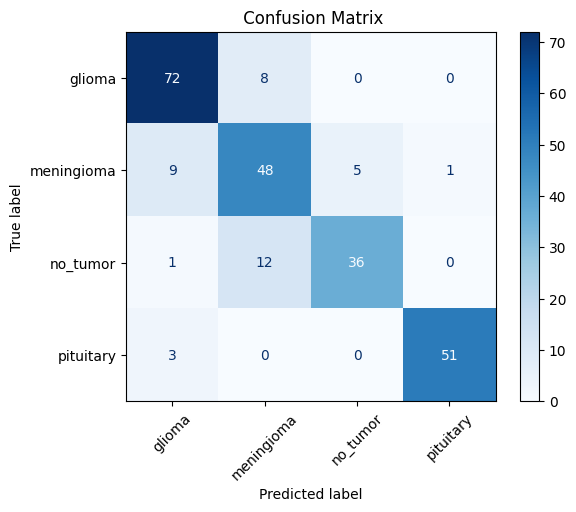

In [7]:
# 7. Load Best Model and Test Evaluation
BEST_MODEL.load_state_dict(torch.load(MODEL_PATH))
BEST_MODEL.to(device)
BEST_MODEL.eval()

# Get predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = BEST_MODEL(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\n Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(" Confusion Matrix")
plt.show()


In [8]:
resnet = models.resnet50(pretrained=True)
resnet_model = resnet.to(device)
train_model(resnet_model, train_loader, val_loader)

C:\ProgramData\anaconda3\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\envs\gpu_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch 1/10: 100%|██████████| 106/106 [00:23<00:00,  4.58it/s]


 Epoch 1/10 | Loss: 87.905 | Val Acc: 82.67% | Time: 26.5s


Epoch 2/10: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s]


 Epoch 2/10 | Loss: 46.249 | Val Acc: 86.45% | Time: 26.7s


Epoch 3/10: 100%|██████████| 106/106 [00:23<00:00,  4.52it/s]


 Epoch 3/10 | Loss: 34.251 | Val Acc: 93.43% | Time: 26.9s
 Best model saved!


Epoch 4/10: 100%|██████████| 106/106 [00:23<00:00,  4.54it/s]


 Epoch 4/10 | Loss: 29.150 | Val Acc: 88.84% | Time: 26.7s


Epoch 5/10: 100%|██████████| 106/106 [00:23<00:00,  4.50it/s]


 Epoch 5/10 | Loss: 24.223 | Val Acc: 91.63% | Time: 26.9s


Epoch 6/10: 100%|██████████| 106/106 [00:23<00:00,  4.55it/s]


 Epoch 6/10 | Loss: 23.020 | Val Acc: 60.36% | Time: 26.7s


Epoch 7/10: 100%|██████████| 106/106 [00:23<00:00,  4.60it/s]


 Epoch 7/10 | Loss: 24.414 | Val Acc: 93.63% | Time: 26.4s
 Best model saved!


Epoch 8/10: 100%|██████████| 106/106 [00:23<00:00,  4.59it/s]


 Epoch 8/10 | Loss: 19.011 | Val Acc: 89.44% | Time: 26.4s


Epoch 9/10: 100%|██████████| 106/106 [00:23<00:00,  4.59it/s]


 Epoch 9/10 | Loss: 15.468 | Val Acc: 82.87% | Time: 26.5s


Epoch 10/10: 100%|██████████| 106/106 [00:23<00:00,  4.54it/s]


 Epoch 10/10 | Loss: 15.480 | Val Acc: 88.65% | Time: 26.7s



 Test Accuracy: 91.46%

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94        80
  meningioma       0.83      0.92      0.87        63
    no_tumor       0.92      0.92      0.92        49
   pituitary       0.94      0.91      0.92        54

    accuracy                           0.91       246
   macro avg       0.92      0.91      0.91       246
weighted avg       0.92      0.91      0.92       246



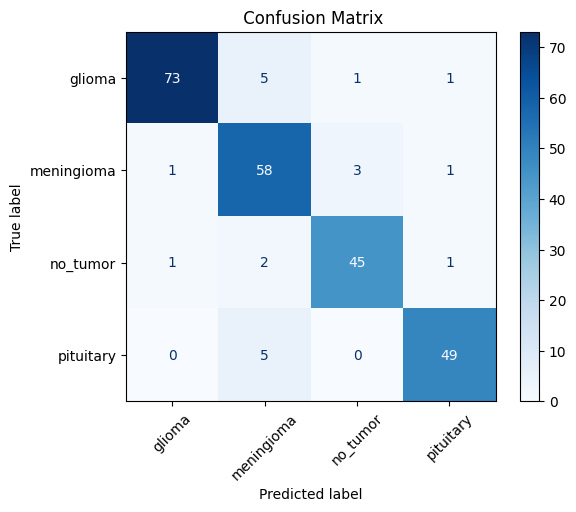

In [9]:
# 5. Load Best Model and Test Evaluation
BEST_MODEL.load_state_dict(torch.load(MODEL_PATH))
BEST_MODEL.to(device)
BEST_MODEL.eval()

# Get predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = BEST_MODEL(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\n Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(" Confusion Matrix")
plt.show()


In [10]:
mobile_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
mobilenet_model = mobile_model.to(device)
train_model(mobilenet_model, train_loader, val_loader)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Epoch 1/10: 100%|██████████| 106/106 [00:13<00:00,  8.12it/s]


 Epoch 1/10 | Loss: 78.726 | Val Acc: 88.84% | Time: 15.6s


Epoch 2/10: 100%|██████████| 106/106 [00:13<00:00,  8.06it/s]


 Epoch 2/10 | Loss: 26.731 | Val Acc: 93.03% | Time: 15.6s


Epoch 3/10: 100%|██████████| 106/106 [00:13<00:00,  8.08it/s]


 Epoch 3/10 | Loss: 16.837 | Val Acc: 93.82% | Time: 15.5s
 Best model saved!


Epoch 4/10: 100%|██████████| 106/106 [00:13<00:00,  7.99it/s]


 Epoch 4/10 | Loss: 13.535 | Val Acc: 92.83% | Time: 15.8s


Epoch 5/10: 100%|██████████| 106/106 [00:12<00:00,  8.31it/s]


 Epoch 5/10 | Loss: 16.131 | Val Acc: 92.83% | Time: 15.1s


Epoch 6/10: 100%|██████████| 106/106 [00:12<00:00,  8.19it/s]


 Epoch 6/10 | Loss: 12.642 | Val Acc: 95.82% | Time: 15.4s
 Best model saved!


Epoch 7/10: 100%|██████████| 106/106 [00:13<00:00,  8.10it/s]


 Epoch 7/10 | Loss: 10.343 | Val Acc: 94.82% | Time: 15.5s


Epoch 8/10: 100%|██████████| 106/106 [00:13<00:00,  8.14it/s]


 Epoch 8/10 | Loss: 9.572 | Val Acc: 94.82% | Time: 15.4s


Epoch 9/10: 100%|██████████| 106/106 [00:12<00:00,  8.30it/s]


 Epoch 9/10 | Loss: 8.170 | Val Acc: 96.81% | Time: 15.1s
 Best model saved!


Epoch 10/10: 100%|██████████| 106/106 [00:12<00:00,  8.21it/s]


 Epoch 10/10 | Loss: 8.496 | Val Acc: 96.41% | Time: 15.3s



 Test Accuracy: 97.15%

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98        80
  meningioma       0.94      0.95      0.94        63
    no_tumor       0.98      0.96      0.97        49
   pituitary       0.98      1.00      0.99        54

    accuracy                           0.97       246
   macro avg       0.97      0.97      0.97       246
weighted avg       0.97      0.97      0.97       246



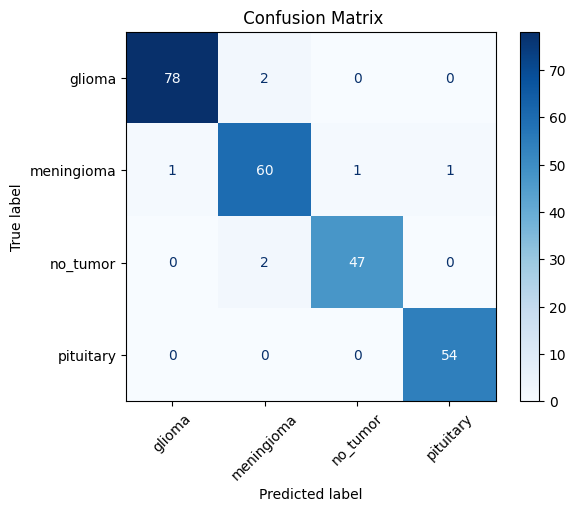

In [11]:
# 5. Load Best Model and Test Evaluation
BEST_MODEL.load_state_dict(torch.load(MODEL_PATH))
BEST_MODEL.to(device)
BEST_MODEL.eval()

# Get predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = BEST_MODEL(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\n Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(" Confusion Matrix")
plt.show()


In [12]:
efficient_model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
efficientnet_model = efficient_model.to(device)
train_model(efficientnet_model, train_loader, val_loader)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Epoch 1/10: 100%|██████████| 106/106 [00:15<00:00,  6.91it/s]


 Epoch 1/10 | Loss: 84.700 | Val Acc: 92.03% | Time: 18.0s


Epoch 2/10: 100%|██████████| 106/106 [00:14<00:00,  7.16it/s]


 Epoch 2/10 | Loss: 21.620 | Val Acc: 90.24% | Time: 17.2s


Epoch 3/10: 100%|██████████| 106/106 [00:14<00:00,  7.25it/s]


 Epoch 3/10 | Loss: 19.420 | Val Acc: 96.81% | Time: 17.2s


Epoch 4/10: 100%|██████████| 106/106 [00:14<00:00,  7.28it/s]


 Epoch 4/10 | Loss: 14.137 | Val Acc: 92.83% | Time: 17.1s


Epoch 5/10: 100%|██████████| 106/106 [00:14<00:00,  7.35it/s]


 Epoch 5/10 | Loss: 10.665 | Val Acc: 95.82% | Time: 16.9s


Epoch 6/10: 100%|██████████| 106/106 [00:14<00:00,  7.35it/s]


 Epoch 6/10 | Loss: 8.042 | Val Acc: 94.62% | Time: 16.8s


Epoch 7/10: 100%|██████████| 106/106 [00:14<00:00,  7.33it/s]


 Epoch 7/10 | Loss: 11.371 | Val Acc: 97.01% | Time: 16.9s
 Best model saved!


Epoch 8/10: 100%|██████████| 106/106 [00:14<00:00,  7.18it/s]


 Epoch 8/10 | Loss: 7.159 | Val Acc: 97.61% | Time: 17.3s
 Best model saved!


Epoch 9/10: 100%|██████████| 106/106 [00:14<00:00,  7.21it/s]


 Epoch 9/10 | Loss: 8.990 | Val Acc: 95.82% | Time: 17.1s


Epoch 10/10: 100%|██████████| 106/106 [00:14<00:00,  7.28it/s]


 Epoch 10/10 | Loss: 11.895 | Val Acc: 96.81% | Time: 16.9s



 Test Accuracy: 95.53%

 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99        80
  meningioma       0.98      0.87      0.92        63
    no_tumor       0.90      0.96      0.93        49
   pituitary       0.93      1.00      0.96        54

    accuracy                           0.96       246
   macro avg       0.95      0.95      0.95       246
weighted avg       0.96      0.96      0.95       246



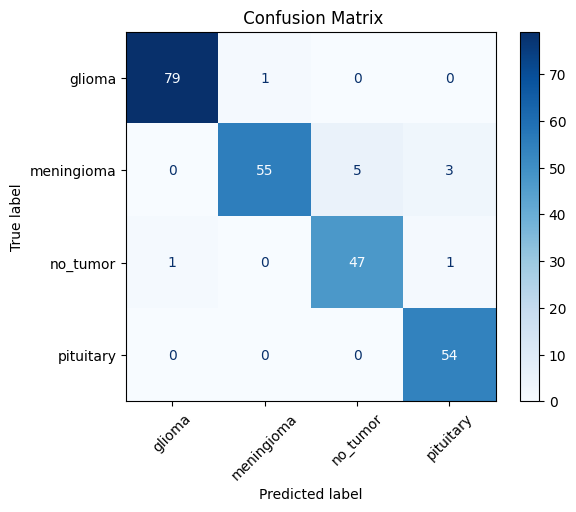

In [13]:
# 5. Load Best Model and Test Evaluation
BEST_MODEL.load_state_dict(torch.load(MODEL_PATH))
BEST_MODEL.to(device)
BEST_MODEL.eval()

# Get predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = BEST_MODEL(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Accuracy
test_acc = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\n Test Accuracy: {test_acc:.2f}%")

# Classification Report
print("\n Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title(" Confusion Matrix")
plt.show()


In [14]:
# from torchvision import models
# import torch.nn as nn

# cnn_model = Custom_CNN().to(device)
# train_model(cnn_model,train_loader,val_loader)

# #Load pretrained model
# resnet = models.resnet50(pretrained=True)
# resnet_model = resnet.to(device)
# train_model(resnet_model, train_loader, val_loader)

# # # Freeze all layers first
# # for param in resnet.parameters():
# #     param.requires_grad = False

# # # Unfreeze only layer4
# # for name, param in resnet.named_parameters():
# #     if "layer4" in name:
# #         param.requires_grad = True

# # # Replace the classifier head (FC block)
# # in_features = resnet.fc.in_features
# # resnet.fc = nn.Sequential(
# #     nn.Linear(in_features, 512),
# #     nn.BatchNorm1d(512),
# #     nn.ReLU(),
# #     nn.Dropout(0.4),
# #     nn.Linear(512, 256),
# #     nn.ReLU(),
# #     nn.Dropout(0.2),
# #     nn.Linear(256, NUM_CLASSES)
# # ).to(device)

# # resnet_model = resnet.to(device)

# # train_model(resnet_model, train_loader, val_loader)

# #MobileNet
# mobile_model = models.mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)
# mobilenet_model = mobile_model.to(device)
# train_model(mobilenet_model, train_loader, val_loader)
# # for param in mobilenet_model.parameters():
# #     param.requires_grad = False
# # Replace the classifier head,
# # in_features = mobilenet_model.classifier[1].in_features
# # mobilenet_model.classifier = nn.Sequential(
# #     nn.Dropout(0.2),
# #     nn.Linear(in_features, NUM_CLASSES)
# # )

# # train_model(mobilenet_model, train_loader, val_loader)

# #EfficientNet
# efficient_model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
# efficientnet_model = efficient_model.to(device)
# train_model(efficientnet_model, train_loader, val_loader)
# # for param in efficientnet_model.parameters():
# #     param.requires_grad = False
# # Replace the classifier head,
# # in_features = efficientnet_model.classifier[1].in_features
# # efficientnet_model.classifier = nn.Sequential(
# #     nn.Dropout(0.2),
# #     nn.Linear(in_features, NUM_CLASSES))


# # train_model(efficientnet_model, train_loader, val_loader)